In [1]:
# ===== Section 1: Imports & Global Setup =====

# General
import os, json, random, warnings
import numpy as np
import pandas as pd

# Imaging
import cv2
from PIL import Image

# Wavelets
import pywt

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Sklearn metrics/split
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix

# Viz
import matplotlib.pyplot as plt
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[INFO] Device:", DEVICE)

# Reproducibility
def seed_everything(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
seed_everything(42)

# User paths (edit if needed)
IMAGE_DIR = "/kaggle/input/fundus-images/Fundus_CIMT_2903/Fundus_CIMT_2903 Dataset"
JSON_PATH = "/kaggle/input/fundus-images/data_info.json"

# Simple helpers
def sigmoid_np(x): 
    return 1.0 / (1.0 + np.exp(-x))

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)

OUT_DIR = "/kaggle/working"
ensure_dir(OUT_DIR)
print("[INFO] Output dir:", OUT_DIR)


[INFO] Device: cuda
[INFO] Output dir: /kaggle/working


In [2]:
# ===== Section 2: Data Loading & Simple Preprocessing =====

# --- 2.1 Load JSON (patient-level metadata) ---
with open(JSON_PATH, "r") as f:
    meta = json.load(f)

patients = []
for pid, info in meta.items():
    thickness = float(info["thickness"])         # CIMT in mm
    label = 1 if thickness > 0.8 else 0          # risk label rule
    patients.append({
        "patient_id": str(pid),
        "gender": int(info["gender"]),
        "true_age": int(info["True_age"]),
        "age_norm": float(info["age"]),          # already normalized in your JSON
        "cimt_mm": thickness,
        "label": label,
        "left_eye": info["left_eye"],
        "right_eye": info["right_eye"],
    })

patients_df = pd.DataFrame(patients)
print(f"[INFO] Patients loaded: {len(patients_df)}")

# --- 2.2 Expand to one row per eye (easier for training) ---
eye_rows = []
for _, r in patients_df.iterrows():
    for eye_tag, fname in [("L", r["left_eye"]), ("R", r["right_eye"])]:
        path = os.path.join(IMAGE_DIR, fname)
        eye_rows.append({
            "patient_id": r["patient_id"],
            "eye": eye_tag,
            "path": path,
            "label": r["label"],          # classification target
            "cimt_mm": r["cimt_mm"],      # available if we do multitask later
            "age_norm": r["age_norm"],    # metadata (will be used)
            "gender": r["gender"],        # metadata (will be used)
        })
eyes_df = pd.DataFrame(eye_rows)

# --- 2.3 Basic file check (so loaders won't crash) ---
eyes_df["exists"] = eyes_df["path"].apply(os.path.exists)
missing = eyes_df[~eyes_df["exists"]]
if len(missing) > 0:
    print(f"[WARN] Missing image files: {len(missing)} (showing 5)")
    display(missing.head())
eyes_df = eyes_df[eyes_df["exists"]].drop(columns=["exists"]).reset_index(drop=True)
print(f"[INFO] Eye images available: {len(eyes_df)}")

# --- 2.4 Simple preprocessing (beginner-friendly, reusable) ---
def load_and_preprocess(path: str, out_size: int = 256) -> torch.Tensor:
    """
    Steps:
      1) read image (OpenCV BGR) and convert to RGB
      2) take GREEN channel (vessels show best)
      3) resize to out_size x out_size
      4) scale to [0,1]
    Returns: FloatTensor (1, H, W)
    """
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    g = img[:, :, 1]                                    # green channel
    g = cv2.resize(g, (out_size, out_size), interpolation=cv2.INTER_AREA)
    g = g.astype(np.float32) / 255.0                    # normalize to [0,1]
    return torch.from_numpy(g).unsqueeze(0)             # (1, H, W)

# --- 2.5 Quick smoke test (reads 2 images and preprocesses) ---
try:
    for p in eyes_df["path"].head(2):
        _ = load_and_preprocess(p, out_size=256)
    print("[INFO] Preprocessing smoke test passed on 2 samples.")
except Exception as e:
    print("[ERROR] Preprocessing test failed:", e)

# Keep for later sections:
#   patients_df : one row per patient (with labels/CIMT & meta)
#   eyes_df     : one row per eye (image path + targets + meta)


[INFO] Patients loaded: 2903
[INFO] Eye images available: 5806
[INFO] Preprocessing smoke test passed on 2 samples.


In [3]:
# ===== Section 3 (Updated): Wavelet Front-end using ONLY LH & HL =====

import pywt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

def make_wavelet_kernels_2d(wavelet_name: str = "db4"):
    w = pywt.Wavelet(wavelet_name)
    lo = np.asarray(w.dec_lo, dtype=np.float32)
    hi = np.asarray(w.dec_hi, dtype=np.float32)

    def outer(a, b): return np.outer(a, b).astype(np.float32)

    LL = outer(lo, lo)
    LH = outer(lo, hi)
    HL = outer(hi, lo)
    HH = outer(hi, hi)

    K = [LL, LH, HL, HH]
    K = [k / (np.linalg.norm(k) + 1e-8) for k in K]
    return K  # [LL, LH, HL, HH]

class SimpleWaveletLayer(nn.Module):
    """
    Input :  (B,1,H,W)
    Output:  (B,2*levels,H,W) containing ONLY [LH, HL] at each level
             (We still use LL internally to compute next level.)
    """
    def __init__(self, levels: int = 2, wavelet: str = "db4"):
        super().__init__()
        assert levels >= 1
        self.levels = levels
        self.wavelet = wavelet

        base_k = make_wavelet_kernels_2d(wavelet)
        ksz = base_k[0].shape[0]

        self.convs = nn.ModuleList()
        for _ in range(levels):
            conv = nn.Conv2d(1, 4, kernel_size=ksz, padding=ksz // 2, bias=False)
            with torch.no_grad():
                w = np.stack(base_k, axis=0)  # (4,k,k)
                conv.weight.copy_(torch.tensor(w[:, None, :, :], dtype=torch.float32))
            self.convs.append(conv)

        self.freeze()

    def freeze(self):
        for conv in self.convs:
            for p in conv.parameters():
                p.requires_grad = False

    def unfreeze(self):
        for conv in self.convs:
            for p in conv.parameters():
                p.requires_grad = True

    def forward(self, x):
        """
        x: (B,1,H,W)
        returns (B, 2*levels, H, W) corresponding to [LH,HL] per level
        """
        B, _, H, W = x.shape
        feats = []
        cur = x

        for conv in self.convs:
            sb = conv(cur)  # (B,4,H,W) = [LL,LH,HL,HH]

            LH = sb[:, 1:2]  # shape (B,1,H,W)
            HL = sb[:, 2:3]  # shape (B,1,H,W)
            feats.append(LH)
            feats.append(HL)

            # Use LL for next level (internal only)
            LL = sb[:, 0:1]
            LL_ds = F.avg_pool2d(LL, kernel_size=2, stride=2)
            cur = F.interpolate(LL_ds, size=(H, W), mode="bilinear", align_corners=False)

        return torch.cat(feats, dim=1)  # (B, 2*levels, H, W)

# Sanity Test
try:
    sample_path = eyes_df["path"].iloc[0]
    x = load_and_preprocess(sample_path, out_size=256).unsqueeze(0)
    wave = SimpleWaveletLayer(levels=2, wavelet="db4")
    with torch.no_grad():
        y = wave(x)
    print("[INFO] Wavelet LH+HL OK.",
          "Input:", tuple(x.shape), "Output:", tuple(y.shape))
except Exception as e:
    print("[WARN] Test skipped:", e)


[INFO] Wavelet LH+HL OK. Input: (1, 1, 256, 256) Output: (1, 4, 257, 257)


In [4]:
# ===== Section 4 (Updated for LH+HL only): Wavelet + Custom CNN (+SE) + Metadata Fusion =====
# Input  : (B,1,H,W) green image + (B,2) [age_norm, gender]
# Wavelet: SimpleWaveletLayer -> (B, 2*levels, H, W)   # ONLY LH & HL
# CNN    : Conv-BN-ReLU-MaxPool x3 + SE + GAP -> 128
# Meta   : MLP -> 16
# Head   : concat(128 + 16) -> Linear(1)

import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, channels: int, reduction: int = 16):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.fc  = nn.Sequential(
            nn.Linear(channels, max(channels // reduction, 8), bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(max(channels // reduction, 8), channels, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        b, c, _, _ = x.size()
        w = self.avg(x).view(b, c)
        w = self.fc(w).view(b, c, 1, 1)
        return x * w

class SimpleCNNBackbone(nn.Module):
    def __init__(self, in_ch: int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.se  = SEBlock(128, reduction=16)
        self.gap = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.se(x)
        return self.gap(x).flatten(1)  # (B,128)

class MetaMLP(nn.Module):
    def __init__(self, in_dim: int = 2, hidden: int = 16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(inplace=True),
            nn.Linear(hidden, hidden), nn.ReLU(inplace=True),
        )
    def forward(self, m):  # (B,2) -> (B,16)
        return self.net(m)

class WaveletCNNClassifier(nn.Module):
    """
    image(1xHxW) --wavelet(levels,wavelet)-> (B, 2*levels, H, W)  # LH+HL only
      -> CNN(128) + Meta(16) -> concat(144) -> Linear(1)
    """
    def __init__(self, levels: int = 3, wavelet: str = "db4"):
        super().__init__()
        self.wavelet_name = wavelet
        self.levels = levels
        self.wave = SimpleWaveletLayer(levels=levels, wavelet=wavelet)  # from Section 3 (LH+HL)
        self.cnn  = SimpleCNNBackbone(in_ch=2 * levels)                 # <-- CHANGED
        self.meta = MetaMLP(in_dim=2, hidden=16)
        self.head = nn.Linear(128 + 16, 1)

    def freeze_wavelets(self): self.wave.freeze()
    def unfreeze_wavelets(self): self.wave.unfreeze()

    def forward(self, img_1ch: torch.Tensor, meta_2: torch.Tensor):
        sb   = self.wave(img_1ch)        # (B, 2*levels, H, W)
        feat = self.cnn(sb)              # (B,128)
        mvec = self.meta(meta_2)         # (B,16)
        z    = torch.cat([feat, mvec], dim=1)  # (B,144)
        return self.head(z)              # (B,1)

# ---- quick sanity check ----
try:
    sample_path = eyes_df["path"].iloc[0]
    x = load_and_preprocess(sample_path, out_size=256).unsqueeze(0)   # (1,1,H,W)
    m = torch.tensor([[0.5, 0.0]], dtype=torch.float32)               # (1,2)
    model = WaveletCNNClassifier(levels=2, wavelet="db4")
    with torch.no_grad():
        out = model(x, m)
    print(f"[INFO] Model OK with LH+HL. In: {tuple(x.shape)} Out: {tuple(out.shape)} "
          f"| wavelet={model.wavelet_name} | levels={model.levels}")
except Exception as e:
    print("[WARN] Model test skipped/failed:", e)


[INFO] Model OK with LH+HL. In: (1, 1, 256, 256) Out: (1, 1) | wavelet=db4 | levels=2


In [5]:
# ===== Section 5: Dataset + Patient-level Split + DataLoaders (metadata-ready) =====

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# -----------------
# 5.1 Patient-level split (avoid leakage)
# -----------------
pids = patients_df["patient_id"].values
labels = patients_df["label"].values

pid_train, pid_temp, y_train, y_temp = train_test_split(
    pids, labels, test_size=0.30, random_state=42, stratify=labels
)
pid_val, pid_test, y_val, y_test = train_test_split(
    pid_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"[INFO] Patients -> train:{len(pid_train)}  val:{len(pid_val)}  test:{len(pid_test)}")

def eyes_subset(df, pid_list):
    s = set(map(str, pid_list))
    return df[df["patient_id"].isin(s)].reset_index(drop=True)

train_df = eyes_subset(eyes_df, pid_train)
val_df   = eyes_subset(eyes_df, pid_val)
test_df  = eyes_subset(eyes_df, pid_test)

print(f"[INFO] Eye rows -> train:{len(train_df)}  val:{len(val_df)}  test:{len(test_df)}")

# -----------------
# 5.2 Dataset (returns: image, metadata([age_norm, gender]), label, pid)
# -----------------
class FundusEyeDataset(Dataset):
    def __init__(self, df, out_size=256, augment=False):
        self.df = df.reset_index(drop=True)
        self.out_size = out_size
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def _augment(self, img):  # img: (1,H,W) tensor
        # simple, safe augmentation
        if torch.rand(()) < 0.5:
            img = torch.flip(img, dims=[2])  # horizontal flip
        return img

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        img = load_and_preprocess(r["path"], out_size=self.out_size)  # (1,H,W) float32 [0..1]
        if self.augment:
            img = self._augment(img)

        meta = torch.tensor([float(r["age_norm"]), float(r["gender"])], dtype=torch.float32)  # (2,)
        label = torch.tensor([float(r["label"])], dtype=torch.float32)  # (1,)
        pid = r["patient_id"]
        return img, meta, label, pid

# -----------------
# 5.3 DataLoaders (beginner-friendly defaults)
# -----------------
IMG_SIZE   = 384    # you can set 384 later for higher accuracy
BATCH_SIZE = 16
NUM_WORKERS = 2

train_loader = DataLoader(
    FundusEyeDataset(train_df, out_size=IMG_SIZE, augment=True),
    batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True
)
val_loader = DataLoader(
    FundusEyeDataset(val_df, out_size=IMG_SIZE, augment=False),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)
test_loader = DataLoader(
    FundusEyeDataset(test_df, out_size=IMG_SIZE, augment=False),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True
)

print("[INFO] Dataloaders ready.",
      f" Train batches: {len(train_loader)} | Val: {len(val_loader)} | Test: {len(test_loader)}")

# Helpful class balance print (patient-level)
print(f"[INFO] Train label balance (patients): pos={int((y_train==1).sum())} neg={int((y_train==0).sum())}")


[INFO] Patients -> train:2032  val:435  test:436
[INFO] Eye rows -> train:4064  val:870  test:872
[INFO] Dataloaders ready.  Train batches: 254 | Val: 55 | Test: 55
[INFO] Train label balance (patients): pos=1438 neg=594


In [6]:
# ===== Section 6: Reusable training function (for any wavelet) =====

# We keep it beginner-friendly:
# - Balanced BCE + Focal (helps hard cases)
# - Early unfreeze of wavelets after a short warmup
# - Simple LR step-down schedule
# - Saves best model (by validation AUROC)

class FocalLoss(nn.Module):
    def __init__(self, gamma: float = 2.0, alpha: float = 0.25):
        super().__init__()
        self.gamma = gamma
        self.alpha = alpha
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        p  = torch.sigmoid(logits)
        pt = p * targets + (1 - p) * (1 - targets)
        w  = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        loss = -w * (1 - pt).pow(self.gamma) * torch.log(pt.clamp_min(1e-7))
        return loss.mean()

@torch.no_grad()
def _evaluate_val(val_loader, model, criterion):
    """Return dict(loss, auroc) on the validation set."""
    model.eval()
    total_loss, n = 0.0, 0
    all_probs, all_labels = [], []
    for x, m, y, _pid in val_loader:
        x, m, y = x.to(DEVICE), m.to(DEVICE), y.to(DEVICE)
        logits = model(x, m)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0); n += x.size(0)
        all_probs.append(sigmoid_np(logits.squeeze(1).cpu().numpy()))
        all_labels.append(y.squeeze(1).cpu().numpy())
    probs  = np.concatenate(all_probs) if all_probs else np.array([])
    labels = np.concatenate(all_labels) if all_labels else np.array([])
    try:
        auroc = roc_auc_score(labels, probs)
    except Exception:
        auroc = float("nan")
    return {"loss": total_loss / max(n, 1), "auroc": auroc}

def train_model(
    wavelet: str = "db4",
    levels: int = 3,
    epochs: int = 30,
    warmup_epochs: int = 1,
    lr: float = 3e-4,
    save_dir: str = OUT_DIR
):
    """
    Trains a Wavelet+CNN+Metadata model for a given wavelet.
    Saves best checkpoint (by val AUROC) at {save_dir}/best_{wavelet}.pth
    Returns: best_path, best_val_auc
    """
    print(f"\n[TRAIN] wavelet={wavelet} | levels={levels} | epochs={epochs} | lr={lr}")

    # --- Build model ---
    model = WaveletCNNClassifier(levels=levels, wavelet=wavelet).to(DEVICE)
    model.freeze_wavelets()  # unfreezed after warmup

    # --- Loss (balanced BCE + Focal) ---
    pos_count = float((train_df["label"] == 1).sum())
    neg_count = float((train_df["label"] == 0).sum())
    pos_weight = torch.tensor([neg_count / max(pos_count, 1.0)], dtype=torch.float32, device=DEVICE)

    bce   = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    focal = FocalLoss(gamma=2.0, alpha=0.25)
    def criterion(logits, y):
        return 0.5 * bce(logits, y) + 0.5 * focal(logits, y)

    # --- Optimizer + simple LR step-down ---
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    def maybe_step_down(epoch):
        if epoch in (12, 24):  # you can add 48 for very long runs
            for g in optimizer.param_groups: g["lr"] *= 0.5
            print(f"[INFO] LR -> {optimizer.param_groups[0]['lr']:.2e} @ epoch {epoch}")

    # --- Train ---
    best_val_auc = -1.0
    best_path = os.path.join(save_dir, f"best_{wavelet}.pth")

    for epoch in range(1, epochs + 1):
        # unfreeze wavelet filters after warmup
        if epoch == warmup_epochs + 1:
            model.unfreeze_wavelets()
            print("[INFO] Wavelet filters unfrozen.")

        maybe_step_down(epoch)

        model.train()
        running_loss, seen = 0.0, 0
        for x, m, y, _pid in tqdm(train_loader, desc=f"[{wavelet}] Epoch {epoch}/{epochs}", leave=False):
            x, m, y = x.to(DEVICE), m.to(DEVICE), y.to(DEVICE)

            optimizer.zero_grad(set_to_none=True)
            logits = model(x, m)
            loss = criterion(logits, y)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            running_loss += loss.item() * x.size(0)
            seen += x.size(0)

        train_loss = running_loss / max(seen, 1)

        # validate
        val_stats = _evaluate_val(val_loader, model, criterion)
        print(f"[{wavelet}] E{epoch:02d} | train_loss={train_loss:.4f} | "
              f"val_loss={val_stats['loss']:.4f} | val_AUROC={val_stats['auroc']:.4f}")

        # save best
        if val_stats["auroc"] > best_val_auc:
            best_val_auc = val_stats["auroc"]
            torch.save(
                {"model_state": model.state_dict(), "levels": levels, "wavelet": wavelet},
                best_path
            )
            print(f"[{wavelet}] NEW BEST -> {best_path} (val_AUROC={best_val_auc:.4f})")

    print(f"[TRAIN DONE] wavelet={wavelet} | best val AUROC={best_val_auc:.4f} | saved={best_path}")
    return best_path, best_val_auc


In [7]:
# ===== Section 7: Inference helpers — load best model & build patient-level tables =====

import os
import numpy as np
import pandas as pd
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def load_best_model(best_path: str) -> torch.nn.Module:
    """
    Rebuild the WaveletCNNClassifier exactly as trained and load weights.
    """
    assert os.path.exists(best_path), f"Checkpoint not found: {best_path}"
    ckpt = torch.load(best_path, map_location=DEVICE, weights_only=False)
    levels  = int(ckpt.get("levels", 3))
    wavelet = str(ckpt.get("wavelet", "db4"))
    model = WaveletCNNClassifier(levels=levels, wavelet=wavelet).to(DEVICE)
    model.load_state_dict(ckpt["model_state"], strict=True)
    model.eval()
    print(f"[INFO] Loaded model: wavelet={wavelet} | levels={levels} from {best_path}")
    return model


@torch.no_grad()
def predict_patient_tables_TTA(loader, model, tta=4):
    rows=[]; model.eval()
    for x,m,y,pid in loader:
        x,m,y = x.to(DEVICE), m.to(DEVICE), y.to(DEVICE)
        logits = 0
        for t in range(tta):
            xx = x
            if t%2==1: xx = torch.flip(xx, dims=[2])         # H-flip
            if t%4==3: xx = torch.rot90(xx, k=1, dims=[2,3]) # +90°
            logits += model(xx, m)
        probs = (1/(1+torch.exp(-logits/tta))).squeeze(1).cpu().numpy()
        labs  = y.squeeze(1).cpu().numpy().astype(int)
        for i in range(len(probs)):
            rows.append({"pid": pid[i], "prob": float(probs[i]), "label": int(labs[i])})
    eye = pd.DataFrame(rows)
    pat = eye.groupby("pid").agg(prob=("prob","mean"), label=("label","first")).reset_index()
    return eye, pat


def save_tables(prefix: str, eye_df: pd.DataFrame, pat_df: pd.DataFrame, out_dir: str = OUT_DIR):
    eye_p = os.path.join(out_dir, f"{prefix}_eye_probs.csv")
    pat_p = os.path.join(out_dir, f"{prefix}_patient_probs.csv")
    eye_df.to_csv(eye_p, index=False)
    pat_df.to_csv(pat_p, index=False)
    print(f"[INFO] Saved: {eye_p}\n[INFO] Saved: {pat_p}")

# ---- Example usage (optional demo) ----
# After you train a wavelet with train_model(...) in Section 6, do:
# best_path, _ = train_model(wavelet="db4", levels=3, epochs=10)  # quick demo epochs
# model_test = load_best_model(best_path)
# val_eye,  val_pat  = predict_patient_tables(val_loader,  model_test)
# test_eye, test_pat = predict_patient_tables(test_loader, model_test)
# save_tables("db4_val",  val_eye,  val_pat)
# save_tables("db4_test", test_eye, test_pat)


In [8]:
# ===== Section 8: Final evaluation (choose VAL threshold → evaluate on TEST) =====

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix

# --- 8.1 Small metric helpers (patient-level) ---
def metrics_at_threshold(df_pat: pd.DataFrame, thr: float):
    """
    df_pat must have columns: ['pid','prob','label'] at patient level.
    Returns (acc, sens, spec, auroc, cm_tuple)
    """
    y_true = df_pat["label"].values.astype(int)
    y_prob = df_pat["prob"].values
    y_pred = (y_prob >= thr).astype(int)

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)

    acc  = (tp + tn) / max(tp + tn + fp + fn, 1)
    sens = tp / max(tp + fn, 1)  # TPR
    spec = tn / max(tn + fp, 1)  # TNR
    try:
        auroc = roc_auc_score(y_true, y_prob)
    except Exception:
        auroc = float("nan")
    return acc, sens, spec, auroc, (int(tn), int(fp), int(fn), int(tp))

def choose_best_threshold(val_pat: pd.DataFrame, mode: str = "accuracy"):
    """
    mode:
      - 'accuracy': pick thr that maximizes accuracy on validation
      - 'youden'  : pick thr that maximizes (sensitivity + specificity - 1)
    Returns (best_thr, (acc, sens, spec, auroc, cm))
    """
    assert mode in ("accuracy", "youden"), "mode must be 'accuracy' or 'youden'"
    best_thr, best_score, best_stats = 0.5, -1.0, None
    for thr in np.linspace(0.0, 1.0, 101):
        acc, sens, spec, auc, cm = metrics_at_threshold(val_pat, thr)
        score = acc if mode == "accuracy" else (sens + spec - 1.0)
        if score > best_score:
            best_thr, best_score, best_stats = float(thr), score, (acc, sens, spec, auc, cm)
    return best_thr, best_stats

# --- 8.2 Final evaluation wrapper (prints neat summary) ---
def final_eval_from_tables(val_pat: pd.DataFrame,
                           test_pat: pd.DataFrame,
                           mode: str = "accuracy",
                           label: str = "model"):
    """
    Use validation to pick threshold (by 'mode'), then evaluate on test.
    Prints a clean report and returns a dict of results.
    """
    thr, (acc_v, sen_v, spec_v, auc_v, cm_v) = choose_best_threshold(val_pat, mode=mode)
    acc_t, sen_t, spec_t, auc_t, cm_t = metrics_at_threshold(test_pat, thr)

    print("\n================ FINAL EVALUATION ================")
    print(f"Model label     : {label}")
    print(f"Strategy        : {mode}  (threshold chosen on VALIDATION)")
    print(f"Best threshold  : {thr:.2f}\n")

    print("VALIDATION (for threshold selection)")
    print(f"AUROC={auc_v:.4f} | ACC={acc_v:.4f} | SEN={sen_v:.4f} | SPEC={spec_v:.4f} | CM={cm_v}")

    print("\nTEST (using best VAL threshold)")
    print(f"AUROC={auc_t:.4f} | ACC={acc_t:.4f} | SEN={sen_t:.4f} | SPEC={spec_t:.4f} | CM={cm_t}")
    print("==================================================\n")

    return {
        "label": label, "mode": mode, "thr": thr,
        "val_auroc": auc_v, "val_acc": acc_v, "val_sens": sen_v, "val_spec": spec_v, "val_cm": cm_v,
        "test_auroc": auc_t, "test_acc": acc_t, "test_sens": sen_t, "test_spec": spec_t, "test_cm": cm_t,
    }

# --- 8.3 Example usage (works with in-memory tables from Section 7) ---
# If val_pat / test_pat are not in memory (e.g., after a fresh kernel), load the CSVs saved in Section 7:
# val_pat  = pd.read_csv(f"{OUT_DIR}/db4_val_patient_probs.csv")   # if you saved per-wavelet tables
# test_pat = pd.read_csv(f"{OUT_DIR}/db4_test_patient_probs.csv")

# Example (uncomment after you create tables with Section 7):
# results_db4 = final_eval_from_tables(val_pat, test_pat, mode="accuracy", label="db4")
# results_db4_youden = final_eval_from_tables(val_pat, test_pat, mode="youden", label="db4")



[TRAIN] wavelet=db4 | levels=3 | epochs=40 | lr=0.0003


[db4] E01 | train_loss=0.2331 | val_loss=0.2331 | val_AUROC=0.7072
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.7072)


[db4] E02 | train_loss=0.2216 | val_loss=0.2204 | val_AUROC=0.7145
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.7145)


[db4] E03 | train_loss=0.2106 | val_loss=0.2037 | val_AUROC=0.7988
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.7988)


[db4] E04 | train_loss=0.2016 | val_loss=0.1982 | val_AUROC=0.8340
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8340)


[db4] E05 | train_loss=0.1936 | val_loss=0.1876 | val_AUROC=0.8367
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8367)


[db4] E06 | train_loss=0.1873 | val_loss=0.1790 | val_AUROC=0.8571
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8571)


[db4] E07 | train_loss=0.1835 | val_loss=0.1808 | val_AUROC=0.8584
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8584)


[db4] E08 | train_loss=0.1805 | val_loss=0.1754 | val_AUROC=0.8587
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8587)


[db4] E09 | train_loss=0.1780 | val_loss=0.1719 | val_AUROC=0.8613
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8613)


[db4] E10 | train_loss=0.1767 | val_loss=0.1714 | val_AUROC=0.8638
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8638)


[db4] E11 | train_loss=0.1757 | val_loss=0.1708 | val_AUROC=0.8613
[INFO] LR -> 1.50e-04 @ epoch 12


[db4] E12 | train_loss=0.1748 | val_loss=0.1704 | val_AUROC=0.8633


[db4] E13 | train_loss=0.1745 | val_loss=0.1685 | val_AUROC=0.8656
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8656)


[db4] E14 | train_loss=0.1744 | val_loss=0.1684 | val_AUROC=0.8659
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8659)


[db4] E15 | train_loss=0.1738 | val_loss=0.1689 | val_AUROC=0.8639


[db4] E16 | train_loss=0.1740 | val_loss=0.1686 | val_AUROC=0.8648


[db4] E17 | train_loss=0.1740 | val_loss=0.1697 | val_AUROC=0.8641


[db4] E18 | train_loss=0.1735 | val_loss=0.1704 | val_AUROC=0.8636


[db4] E19 | train_loss=0.1735 | val_loss=0.1696 | val_AUROC=0.8638


[db4] E20 | train_loss=0.1734 | val_loss=0.1693 | val_AUROC=0.8637
[INFO] Wavelet filters unfrozen.


[db4] E21 | train_loss=0.1749 | val_loss=0.1711 | val_AUROC=0.8662
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8662)


[db4] E22 | train_loss=0.1734 | val_loss=0.1685 | val_AUROC=0.8656


[db4] E23 | train_loss=0.1736 | val_loss=0.1688 | val_AUROC=0.8654
[INFO] LR -> 7.50e-05 @ epoch 24


[db4] E24 | train_loss=0.1729 | val_loss=0.1688 | val_AUROC=0.8662
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8662)


[db4] E25 | train_loss=0.1727 | val_loss=0.1684 | val_AUROC=0.8664
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8664)


[db4] E26 | train_loss=0.1728 | val_loss=0.1688 | val_AUROC=0.8667
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8667)


[db4] E27 | train_loss=0.1729 | val_loss=0.1693 | val_AUROC=0.8654


[db4] E28 | train_loss=0.1728 | val_loss=0.1684 | val_AUROC=0.8664


[db4] E29 | train_loss=0.1725 | val_loss=0.1685 | val_AUROC=0.8660


[db4] E30 | train_loss=0.1729 | val_loss=0.1697 | val_AUROC=0.8654


[db4] E31 | train_loss=0.1728 | val_loss=0.1696 | val_AUROC=0.8645


[db4] E32 | train_loss=0.1729 | val_loss=0.1690 | val_AUROC=0.8635


[db4] E33 | train_loss=0.1727 | val_loss=0.1683 | val_AUROC=0.8662


[db4] E34 | train_loss=0.1725 | val_loss=0.1683 | val_AUROC=0.8661


[db4] E35 | train_loss=0.1726 | val_loss=0.1687 | val_AUROC=0.8664


[db4] E36 | train_loss=0.1727 | val_loss=0.1689 | val_AUROC=0.8657


[db4] E37 | train_loss=0.1726 | val_loss=0.1694 | val_AUROC=0.8651


[db4] E38 | train_loss=0.1729 | val_loss=0.1680 | val_AUROC=0.8670
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8670)


[db4] E39 | train_loss=0.1723 | val_loss=0.1691 | val_AUROC=0.8669


[db4] E40 | train_loss=0.1726 | val_loss=0.1683 | val_AUROC=0.8670
[db4] NEW BEST -> /kaggle/working/best_db4.pth (val_AUROC=0.8670)
[TRAIN DONE] wavelet=db4 | best val AUROC=0.8670 | saved=/kaggle/working/best_db4.pth
[INFO] Loaded model: wavelet=db4 | levels=3 from /kaggle/working/best_db4.pth
[INFO] Saved: /kaggle/working/db4_val_eye_probs.csv
[INFO] Saved: /kaggle/working/db4_val_patient_probs.csv
[INFO] Saved: /kaggle/working/db4_test_eye_probs.csv
[INFO] Saved: /kaggle/working/db4_test_patient_probs.csv

================ FINAL EVALUATION ================
Model label     : db4
Strategy        : accuracy  (threshold chosen on VALIDATION)
Best threshold  : 0.37

VALIDATION (for threshold selection)
AUROC=0.8679 | ACC=0.8253 | SEN=0.8831 | SPEC=0.6850 | CM=(87, 40, 36, 272)

TEST (using best VAL threshold)
AUROC=0.8662 | ACC=0.8119 | SEN=0.8604 | SPEC=0.6953 | CM=(89, 39, 43, 265)


[TRAIN] wavelet=bior1.1 | levels=3 | epochs=40 | lr=0.0003


[bior1.1] E01 | train_loss=0.2222 | val_loss=0.2071 | val_AUROC=0.8034
[bior1.1] NEW BEST -> /kaggle/working/best_bior1.1.pth (val_AUROC=0.8034)


[bior1.1] E02 | train_loss=0.2118 | val_loss=0.2010 | val_AUROC=0.8091
[bior1.1] NEW BEST -> /kaggle/working/best_bior1.1.pth (val_AUROC=0.8091)


[bior1.1] E03 | train_loss=0.2057 | val_loss=0.2047 | val_AUROC=0.8173
[bior1.1] NEW BEST -> /kaggle/working/best_bior1.1.pth (val_AUROC=0.8173)


[bior1.1] E04 | train_loss=0.2004 | val_loss=0.1864 | val_AUROC=0.8408
[bior1.1] NEW BEST -> /kaggle/working/best_bior1.1.pth (val_AUROC=0.8408)


[bior1.1] E05 | train_loss=0.1931 | val_loss=0.1932 | val_AUROC=0.8333


[bior1.1] E06 | train_loss=0.1883 | val_loss=0.1787 | val_AUROC=0.8514
[bior1.1] NEW BEST -> /kaggle/working/best_bior1.1.pth (val_AUROC=0.8514)


[bior1.1] E07 | train_loss=0.1851 | val_loss=0.1749 | val_AUROC=0.8599
[bior1.1] NEW BEST -> /kaggle/working/best_bior1.1.pth (val_AUROC=0.8599)


[bior1.1] E08 | train_loss=0.1808 | val_loss=0.1737 | val_AUROC=0.8626
[bior1.1] NEW BEST -> /kaggle/working/best_bior1.1.pth (val_AUROC=0.8626)


[bior1.1] E09 | train_loss=0.1794 | val_loss=0.1738 | val_AUROC=0.8619


[bior1.1] E10 | train_loss=0.1781 | val_loss=0.1699 | val_AUROC=0.8660
[bior1.1] NEW BEST -> /kaggle/working/best_bior1.1.pth (val_AUROC=0.8660)


[bior1.1] E11 | train_loss=0.1762 | val_loss=0.1686 | val_AUROC=0.8677
[bior1.1] NEW BEST -> /kaggle/working/best_bior1.1.pth (val_AUROC=0.8677)
[INFO] LR -> 1.50e-04 @ epoch 12


[bior1.1] E12 | train_loss=0.1755 | val_loss=0.1697 | val_AUROC=0.8666


[bior1.1] E13 | train_loss=0.1756 | val_loss=0.1693 | val_AUROC=0.8664


[bior1.1] E14 | train_loss=0.1748 | val_loss=0.1694 | val_AUROC=0.8657


[bior1.1] E15 | train_loss=0.1753 | val_loss=0.1688 | val_AUROC=0.8658


[bior1.1] E16 | train_loss=0.1750 | val_loss=0.1684 | val_AUROC=0.8670


[bior1.1] E17 | train_loss=0.1745 | val_loss=0.1677 | val_AUROC=0.8674


[bior1.1] E18 | train_loss=0.1743 | val_loss=0.1682 | val_AUROC=0.8657


[bior1.1] E19 | train_loss=0.1739 | val_loss=0.1700 | val_AUROC=0.8656


[bior1.1] E20 | train_loss=0.1746 | val_loss=0.1676 | val_AUROC=0.8673
[INFO] Wavelet filters unfrozen.


[bior1.1] E21 | train_loss=0.1741 | val_loss=0.1679 | val_AUROC=0.8662


[bior1.1] E22 | train_loss=0.1744 | val_loss=0.1686 | val_AUROC=0.8654


[bior1.1] E23 | train_loss=0.1743 | val_loss=0.1684 | val_AUROC=0.8659
[INFO] LR -> 7.50e-05 @ epoch 24


[bior1.1] E24 | train_loss=0.1737 | val_loss=0.1696 | val_AUROC=0.8659


[bior1.1] E25 | train_loss=0.1735 | val_loss=0.1685 | val_AUROC=0.8663


[bior1.1] E26 | train_loss=0.1737 | val_loss=0.1682 | val_AUROC=0.8651


[bior1.1] E27 | train_loss=0.1738 | val_loss=0.1680 | val_AUROC=0.8659


[bior1.1] E28 | train_loss=0.1734 | val_loss=0.1688 | val_AUROC=0.8663


[bior1.1] E29 | train_loss=0.1735 | val_loss=0.1681 | val_AUROC=0.8660


[bior1.1] E30 | train_loss=0.1736 | val_loss=0.1682 | val_AUROC=0.8658


[bior1.1] E31 | train_loss=0.1736 | val_loss=0.1681 | val_AUROC=0.8661


[bior1.1] E32 | train_loss=0.1733 | val_loss=0.1687 | val_AUROC=0.8647


[bior1.1] E33 | train_loss=0.1732 | val_loss=0.1684 | val_AUROC=0.8659


[bior1.1] E34 | train_loss=0.1734 | val_loss=0.1680 | val_AUROC=0.8657


[bior1.1] E35 | train_loss=0.1734 | val_loss=0.1680 | val_AUROC=0.8658


[bior1.1] E36 | train_loss=0.1732 | val_loss=0.1687 | val_AUROC=0.8653


[bior1.1] E37 | train_loss=0.1734 | val_loss=0.1683 | val_AUROC=0.8651


[bior1.1] E38 | train_loss=0.1734 | val_loss=0.1683 | val_AUROC=0.8649


[bior1.1] E39 | train_loss=0.1731 | val_loss=0.1682 | val_AUROC=0.8650


[bior1.1] E40 | train_loss=0.1730 | val_loss=0.1685 | val_AUROC=0.8646
[TRAIN DONE] wavelet=bior1.1 | best val AUROC=0.8677 | saved=/kaggle/working/best_bior1.1.pth
[INFO] Loaded model: wavelet=bior1.1 | levels=3 from /kaggle/working/best_bior1.1.pth
[INFO] Saved: /kaggle/working/bior1.1_val_eye_probs.csv
[INFO] Saved: /kaggle/working/bior1.1_val_patient_probs.csv
[INFO] Saved: /kaggle/working/bior1.1_test_eye_probs.csv
[INFO] Saved: /kaggle/working/bior1.1_test_patient_probs.csv

================ FINAL EVALUATION ================
Model label     : bior1.1
Strategy        : accuracy  (threshold chosen on VALIDATION)
Best threshold  : 0.37

VALIDATION (for threshold selection)
AUROC=0.8685 | ACC=0.8299 | SEN=0.9123 | SPEC=0.6299 | CM=(80, 47, 27, 281)

TEST (using best VAL threshold)
AUROC=0.8632 | ACC=0.8050 | SEN=0.8701 | SPEC=0.6484 | CM=(83, 45, 40, 268)


[TRAIN] wavelet=sym5 | levels=3 | epochs=40 | lr=0.0003


[sym5] E01 | train_loss=0.2298 | val_loss=0.2300 | val_AUROC=0.7451
[sym5] NEW BEST -> /kaggle/working/best_sym5.pth (val_AUROC=0.7451)


[sym5] E02 | train_loss=0.2147 | val_loss=0.2080 | val_AUROC=0.7993
[sym5] NEW BEST -> /kaggle/working/best_sym5.pth (val_AUROC=0.7993)


[sym5] E03 | train_loss=0.2036 | val_loss=0.1948 | val_AUROC=0.8209
[sym5] NEW BEST -> /kaggle/working/best_sym5.pth (val_AUROC=0.8209)


[sym5] E04 | train_loss=0.1949 | val_loss=0.1881 | val_AUROC=0.8349
[sym5] NEW BEST -> /kaggle/working/best_sym5.pth (val_AUROC=0.8349)


[sym5] E05 | train_loss=0.1880 | val_loss=0.1821 | val_AUROC=0.8478
[sym5] NEW BEST -> /kaggle/working/best_sym5.pth (val_AUROC=0.8478)


[sym5] E06 | train_loss=0.1830 | val_loss=0.1778 | val_AUROC=0.8546
[sym5] NEW BEST -> /kaggle/working/best_sym5.pth (val_AUROC=0.8546)


[sym5] E07 | train_loss=0.1801 | val_loss=0.1754 | val_AUROC=0.8605
[sym5] NEW BEST -> /kaggle/working/best_sym5.pth (val_AUROC=0.8605)


[sym5] E08 | train_loss=0.1780 | val_loss=0.1736 | val_AUROC=0.8598


[sym5] E09 | train_loss=0.1768 | val_loss=0.1720 | val_AUROC=0.8612
[sym5] NEW BEST -> /kaggle/working/best_sym5.pth (val_AUROC=0.8612)


[sym5] E10 | train_loss=0.1757 | val_loss=0.1986 | val_AUROC=0.8480


[sym5] E11 | train_loss=0.1756 | val_loss=0.1711 | val_AUROC=0.8624
[sym5] NEW BEST -> /kaggle/working/best_sym5.pth (val_AUROC=0.8624)
[INFO] LR -> 1.50e-04 @ epoch 12


[sym5] E12 | train_loss=0.1745 | val_loss=0.1696 | val_AUROC=0.8637
[sym5] NEW BEST -> /kaggle/working/best_sym5.pth (val_AUROC=0.8637)


[sym5] E13 | train_loss=0.1743 | val_loss=0.1694 | val_AUROC=0.8643
[sym5] NEW BEST -> /kaggle/working/best_sym5.pth (val_AUROC=0.8643)


[sym5] E14 | train_loss=0.1742 | val_loss=0.1697 | val_AUROC=0.8638


[sym5] E15 | train_loss=0.1742 | val_loss=0.1701 | val_AUROC=0.8637


[sym5] E16 | train_loss=0.1738 | val_loss=0.1717 | val_AUROC=0.8605


[sym5] E17 | train_loss=0.1741 | val_loss=0.1702 | val_AUROC=0.8630


[sym5] E18 | train_loss=0.1740 | val_loss=0.1719 | val_AUROC=0.8615


[sym5] E19 | train_loss=0.1735 | val_loss=0.1705 | val_AUROC=0.8635


[sym5] E20 | train_loss=0.1736 | val_loss=0.1712 | val_AUROC=0.8618
[INFO] Wavelet filters unfrozen.


[sym5] E21 | train_loss=0.1756 | val_loss=0.1718 | val_AUROC=0.8633


[sym5] E22 | train_loss=0.1742 | val_loss=0.1705 | val_AUROC=0.8658
[sym5] NEW BEST -> /kaggle/working/best_sym5.pth (val_AUROC=0.8658)


[sym5] E23 | train_loss=0.1740 | val_loss=0.1701 | val_AUROC=0.8656
[INFO] LR -> 7.50e-05 @ epoch 24


[sym5] E24 | train_loss=0.1734 | val_loss=0.1706 | val_AUROC=0.8650


[sym5] E25 | train_loss=0.1733 | val_loss=0.1716 | val_AUROC=0.8643


[sym5] E26 | train_loss=0.1734 | val_loss=0.1697 | val_AUROC=0.8652


[sym5] E27 | train_loss=0.1731 | val_loss=0.1697 | val_AUROC=0.8655


[sym5] E28 | train_loss=0.1730 | val_loss=0.1702 | val_AUROC=0.8648


[sym5] E29 | train_loss=0.1731 | val_loss=0.1699 | val_AUROC=0.8653


[sym5] E30 | train_loss=0.1729 | val_loss=0.1715 | val_AUROC=0.8648


[sym5] E31 | train_loss=0.1730 | val_loss=0.1700 | val_AUROC=0.8649


[sym5] E32 | train_loss=0.1729 | val_loss=0.1699 | val_AUROC=0.8643


[sym5] E33 | train_loss=0.1729 | val_loss=0.1699 | val_AUROC=0.8653


[sym5] E34 | train_loss=0.1730 | val_loss=0.1699 | val_AUROC=0.8650


[sym5] E35 | train_loss=0.1729 | val_loss=0.1695 | val_AUROC=0.8656


[sym5] E36 | train_loss=0.1731 | val_loss=0.1712 | val_AUROC=0.8610


[sym5] E37 | train_loss=0.1725 | val_loss=0.1697 | val_AUROC=0.8650


[sym5] E38 | train_loss=0.1728 | val_loss=0.1696 | val_AUROC=0.8646


[sym5] E39 | train_loss=0.1725 | val_loss=0.1695 | val_AUROC=0.8644


[sym5] E40 | train_loss=0.1726 | val_loss=0.1705 | val_AUROC=0.8643
[TRAIN DONE] wavelet=sym5 | best val AUROC=0.8658 | saved=/kaggle/working/best_sym5.pth
[INFO] Loaded model: wavelet=sym5 | levels=3 from /kaggle/working/best_sym5.pth
[INFO] Saved: /kaggle/working/sym5_val_eye_probs.csv
[INFO] Saved: /kaggle/working/sym5_val_patient_probs.csv
[INFO] Saved: /kaggle/working/sym5_test_eye_probs.csv
[INFO] Saved: /kaggle/working/sym5_test_patient_probs.csv

================ FINAL EVALUATION ================
Model label     : sym5
Strategy        : accuracy  (threshold chosen on VALIDATION)
Best threshold  : 0.38

VALIDATION (for threshold selection)
AUROC=0.8658 | ACC=0.8276 | SEN=0.9188 | SPEC=0.6063 | CM=(77, 50, 25, 283)

TEST (using best VAL threshold)
AUROC=0.8678 | ACC=0.8119 | SEN=0.8766 | SPEC=0.6562 | CM=(84, 44, 38, 270)


================ WAVELET COMPARISON (TEST, threshold from VAL) ================
Wavelet Strategy  Best Thr (VAL)  VAL AUROC  VAL ACC  TEST AUROC  TEST ACC  TE

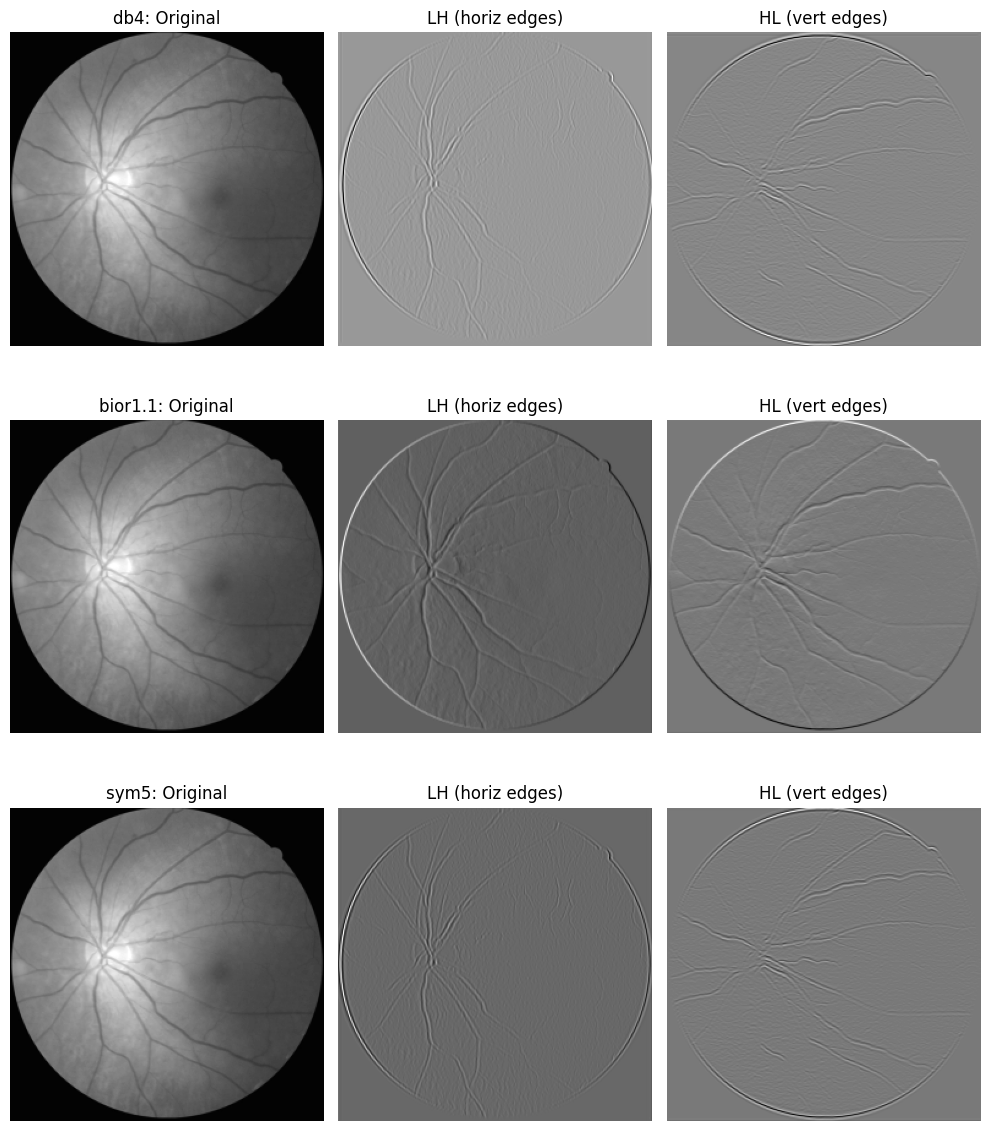

In [9]:
# ===== Section 9: Wavelet sweep (db4 / coif3 / sym5) + comparison + visuals =====
import os, pandas as pd, numpy as np, torch, matplotlib.pyplot as plt

# Config you can tweak:
WAVELETS   = ["db4", "bior1.1", "sym5"]
LEVELS     = 3          # keep in sync with Section 4 default
EPOCHS     = 40     # 50–60 for best results; 30 for quicker runs
LR         = 3e-4
WARMUP_EPS = 20
EVAL_MODE  = "accuracy" # "accuracy" for max ACC; "youden" for balanced point

all_results = []

def visualize_subbands(sample_path: str, wavelet_list, size: int = 256):
    """
    Shows: Original + LH + HL for level=1 for each wavelet in wavelet_list.
    Compatible with the LH+HL-only SimpleWaveletLayer forward().
    """
    import matplotlib.pyplot as plt
    img = load_and_preprocess(sample_path, out_size=size)  # (1,H,W)
    rows, cols = len(wavelet_list), 3
    plt.figure(figsize=(10, 4 * rows))
    for r, wv in enumerate(wavelet_list):
        wav = SimpleWaveletLayer(levels=1, wavelet=wv)
        with torch.no_grad():
            sb = wav(img.unsqueeze(0))  # (1,2,H,W) = [LH,HL]
        LH = sb[0, 0].cpu().numpy()
        HL = sb[0, 1].cpu().numpy()

        ax = plt.subplot(rows, cols, r*cols + 1); ax.imshow(img[0].cpu().numpy(), cmap="gray")
        ax.set_title(f"{wv}: Original"); ax.axis("off")
        ax = plt.subplot(rows, cols, r*cols + 2); ax.imshow(LH, cmap="gray")
        ax.set_title("LH (horiz edges)"); ax.axis("off")
        ax = plt.subplot(rows, cols, r*cols + 3); ax.imshow(HL, cmap="gray")
        ax.set_title("HL (vert edges)"); ax.axis("off")
    plt.tight_layout(); plt.show()

for wv in WAVELETS:
    # 1) Train and save best checkpoint for this wavelet (Section 6)
    best_path, best_val_auc = train_model(
        wavelet=wv, levels=LEVELS, epochs=EPOCHS, warmup_epochs=WARMUP_EPS, lr=LR, save_dir=OUT_DIR
    )

    # 2) Load best model + make patient-level tables (Section 7)
    model_best = load_best_model(best_path)
    val_eye,  val_pat  = predict_patient_tables_TTA(val_loader,  model_best)
    test_eye, test_pat = predict_patient_tables_TTA(test_loader, model_best)

    # Optionally save the tables (handy for audit/repro)
    save_tables(f"{wv}_val",  val_eye,  val_pat,  out_dir=OUT_DIR)
    save_tables(f"{wv}_test", test_eye, test_pat, out_dir=OUT_DIR)

    # 3) Final evaluation using validation-chosen threshold (Section 8)
    res = final_eval_from_tables(val_pat, test_pat, mode=EVAL_MODE, label=wv)
    all_results.append(res)

# 4) Neat comparison table (sorted by Test Accuracy)
cmp = pd.DataFrame([{
    "Wavelet": r["label"],
    "Strategy": r["mode"],
    "Best Thr (VAL)": round(r["thr"], 2),
    "VAL AUROC": round(r["val_auroc"], 4),
    "VAL ACC": round(r["val_acc"], 4),
    "TEST AUROC": round(r["test_auroc"], 4),
    "TEST ACC": round(r["test_acc"], 4),
    "TEST SEN": round(r["test_sens"], 4),
    "TEST SPEC": round(r["test_spec"], 4),
    "TEST CM (tn,fp,fn,tp)": r["test_cm"]
} for r in all_results]).sort_values("TEST ACC", ascending=False).reset_index(drop=True)

print("\n================ WAVELET COMPARISON (TEST, threshold from VAL) ================")
print(cmp.to_string(index=False))

# Optionally save the comparison table
cmp_csv = os.path.join(OUT_DIR, "wavelet_comparison.csv")
cmp.to_csv(cmp_csv, index=False)
print(f"\n[INFO] Saved comparison table -> {cmp_csv}")

# 5) Visualize subbands on a sample fundus image for each wavelet
sample_path = eyes_df["path"].iloc[0]
print(f"\n[INFO] Subband visualization on sample image:\n{sample_path}")
visualize_subbands(sample_path, wavelet_list=WAVELETS, size=256)


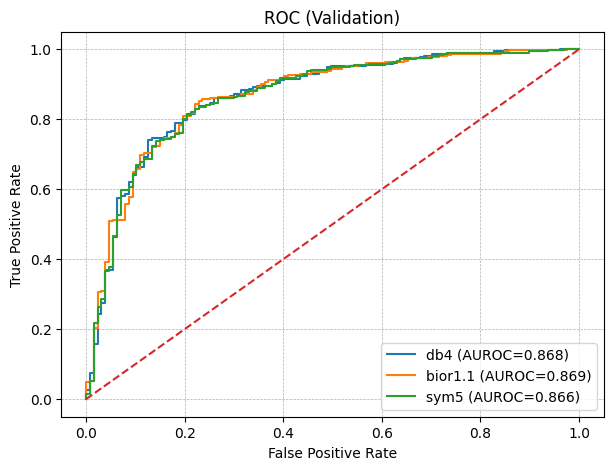

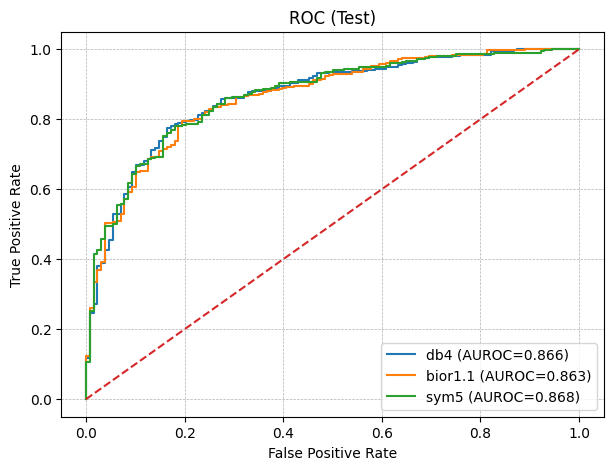

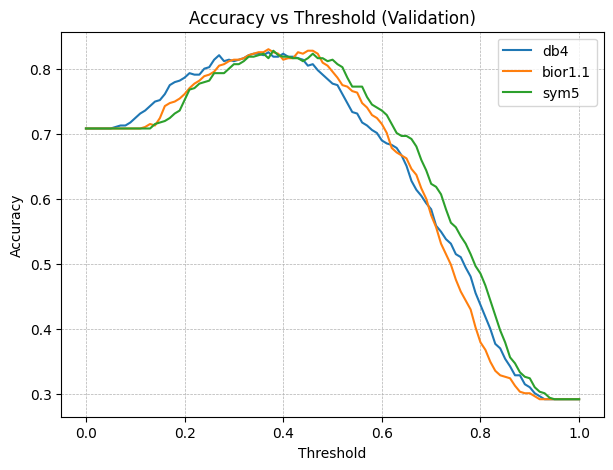

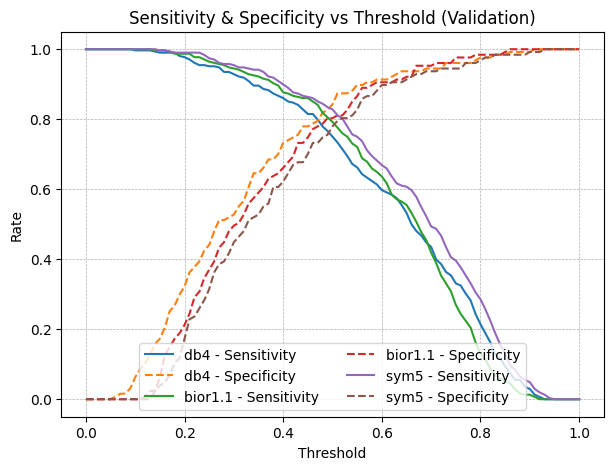

In [10]:
# ===== Section 10: Graphs (ROC + Threshold tradeoffs) for db4 / coif3 / sym5 =====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score

WAVELETS = ["db4", "bior1.1", "sym5"]
DIR = OUT_DIR  # "/kaggle/working" from Section 1

# ---------- helpers ----------
def load_patient_tables(wv: str):
    val_p  = os.path.join(DIR, f"{wv}_val_patient_probs.csv")
    test_p = os.path.join(DIR, f"{wv}_test_patient_probs.csv")
    assert os.path.exists(val_p),  f"Missing: {val_p}. Run Section 9 first."
    assert os.path.exists(test_p), f"Missing: {test_p}. Run Section 9 first."
    val_df  = pd.read_csv(val_p)
    test_df = pd.read_csv(test_p)
    return val_df, test_df

def accuracy_sens_spec(df: pd.DataFrame, thr: float):
    y = df["label"].values.astype(int)
    p = df["prob"].values
    yhat = (p >= thr).astype(int)
    cm = confusion_matrix(y, yhat, labels=[0,1])
    tn, fp, fn, tp = cm.ravel() if cm.size==4 else (0,0,0,0)
    acc  = (tp+tn)/max(tp+tn+fp+fn,1)
    sens = tp/max(tp+fn,1)  # TPR
    spec = tn/max(tn+fp,1)  # TNR
    return acc, sens, spec

def sweep_thresholds(df: pd.DataFrame, steps=101):
    thrs = np.linspace(0, 1, steps)
    accs, senss, specs = [], [], []
    for t in thrs:
        acc, sen, spec = accuracy_sens_spec(df, t)
        accs.append(acc); senss.append(sen); specs.append(spec)
    return thrs, np.array(accs), np.array(senss), np.array(specs)

# ---------- 1) ROC (Validation) overlay ----------
plt.figure(figsize=(7,5))
for wv in WAVELETS:
    val_df, _ = load_patient_tables(wv)
    y = val_df["label"].values.astype(int)
    p = val_df["prob"].values
    fpr, tpr, _ = roc_curve(y, p)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{wv} (AUROC={roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (Validation)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# ---------- 2) ROC (Test) overlay ----------
plt.figure(figsize=(7,5))
for wv in WAVELETS:
    _, test_df = load_patient_tables(wv)
    y = test_df["label"].values.astype(int)
    p = test_df["prob"].values
    fpr, tpr, _ = roc_curve(y, p)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{wv} (AUROC={roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC (Test)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# ---------- 3) Accuracy vs Threshold (Validation) overlay ----------
plt.figure(figsize=(7,5))
for wv in WAVELETS:
    val_df, _ = load_patient_tables(wv)
    thrs, accs, senss, specs = sweep_thresholds(val_df)
    plt.plot(thrs, accs, label=wv)
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold (Validation)")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

# ---------- 4) Sensitivity & Specificity vs Threshold (Validation) overlay ----------
plt.figure(figsize=(7,5))
for wv in WAVELETS:
    val_df, _ = load_patient_tables(wv)
    thrs, accs, senss, specs = sweep_thresholds(val_df)
    plt.plot(thrs, senss, label=f"{wv} - Sensitivity")
    plt.plot(thrs, specs, linestyle="--", label=f"{wv} - Specificity")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Sensitivity & Specificity vs Threshold (Validation)")
plt.legend(ncol=2)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

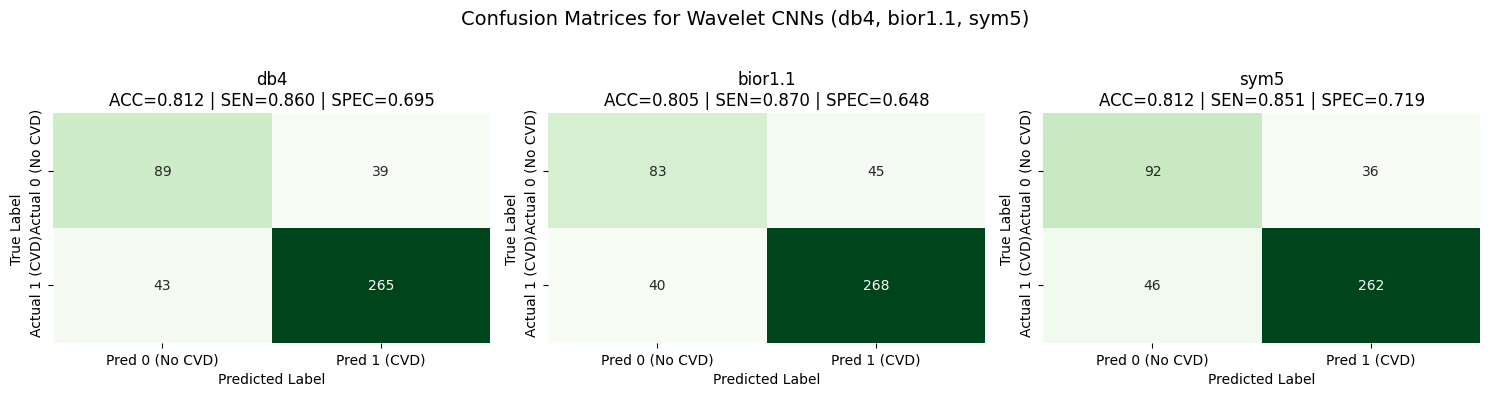

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define your models and thresholds (from final evaluation)
models = {
    "db4": {"path": "/kaggle/working/db4_test_patient_probs.csv", "thr": 0.37},
    "bior1.1": {"path": "/kaggle/working/bior1.1_test_patient_probs.csv", "thr": 0.37},
    "sym5": {"path": "/kaggle/working/sym5_test_patient_probs.csv", "thr": 0.44},
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, info) in zip(axes, models.items()):
    df = pd.read_csv(info["path"])
    thr = info["thr"]

    # Compute predictions
    df["pred"] = (df["prob"] >= thr).astype(int)

    # Confusion matrix
    cm = confusion_matrix(df["label"], df["pred"])
    tn, fp, fn, tp = cm.ravel()
    acc = (tp + tn) / (tp + tn + fp + fn)
    sens = tp / (tp + fn + 1e-7)
    spec = tn / (tn + fp + 1e-7)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Greens",
        cbar=False,
        ax=ax,
        xticklabels=["Pred 0 (No CVD)", "Pred 1 (CVD)"],
        yticklabels=["Actual 0 (No CVD)", "Actual 1 (CVD)"],
    )
    ax.set_title(f"{name}\nACC={acc:.3f} | SEN={sens:.3f} | SPEC={spec:.3f}")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.suptitle("Confusion Matrices for Wavelet CNNs (db4, bior1.1, sym5)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()